In [1]:
#Modules
from matplotlib import pyplot as plt
import numpy as np
import math
from celluloid import Camera

In [2]:
#Custom Functions

#Trapezoid Integration Function
def integrate(u,dx,x_vals):
    area_under_curve = 0
    for i in range(0,len(x_vals)-1):
        area = dx * (u[i+1]+u[i]) / 2
        area_under_curve = area_under_curve + area
    return area_under_curve

#Gaussian Function
def gaussian(x, mu, sigma):
    denom = sigma * ((2 * math.pi)**0.5)
    numerator = math.exp(((x - mu)**2) / ((sigma) **2) / -2)
    res = numerator / denom
    return res

# Habitat Preference
def preference(x):
    pi = math.pi
    res = 0.1 + math.sin(2 * pi * x / 50) ** 2  # Example 1
    #res = math.exp(-0.01*abs(x-50)**2) # Example 2
    res = np.float64(res)
    return res

# 1st Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = (2 * pi / 25) * math.cos(pi * x / 25) * math.sin(pi * x / 25)  # Example 1
    #res = -0.02*math.exp(-0.01*(x-50)**2)*(x-50) # Example 2
    res = np.float64(res)
    return res

# 2nd Derivative of Habitat Preference Function
def preference_slope_slope(x):
    pi = math.pi
    res = (2*pi*pi/625) * math.cos(2*pi*x/25)# Example 1
    #res = -0.02 * ((-0.02 * math.exp(-0.01*(x-50)**2)*(x-50))*(x-50)+1*math.exp(-0.01*(x-50)**2)) # Example 2
    res = np.float64(res)
    return res

#Normalized RMSE

def rmse(model, true, nx, t):
    summation = 0
    for i in range(0,nx):
        dif = (model[t][1][i] - true[0][1][i])**2
        summation = summation + dif
    rmse = (summation/nx)**0.5
    return abs(rmse)

#Convergence Flag

def converge(current_t, t_minus1000, t_minus2000):
    #function to determine whether finite difference scheme has convered
    #inputs are rows of an array
    current_t = np.float128(current_t ** 0.01)
    t_minus50 = np.float128(t_minus1000 ** 0.01)
    t_minus100 = np.float128(t_minus2000 ** 0.01)
    h1 = abs(t_minus1000 - t_minus2000)
    print(h1)
    h2 = abs(current_t - t_minus1000)
    print(h2)
    dif = abs(h1-h2)
    print(dif)
    cuttoff = np.format_float_scientific(np.float128(1e-128), unique=False, precision=128)
    mask = dif>np.float128(cuttoff)
    print(mask)
    if True not in mask:
        print("yes")
        return True
        
    

In [3]:
a = np.array([[0,0,0],[0,0,0],[0,0,0]])
print(a)
converge(a[2],a[1],a[0])

[[0 0 0]
 [0 0 0]
 [0 0 0]]
[0 0 0]
[0. 0. 0.]
[0. 0. 0.]
[False False False]
yes


True

In [4]:
#Model Settings

# Bounds
start = 0 # start bound
stop = 10 # stop bound


# Model parameters
dt = 1 # delta t
dx = 1  # delta x
T = 10 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
mean_sl = 0.04 #mean step length
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

# Fourier Number Flag
if r > 0.5:
    print("Fourier Number " + str(r) +  " > 0.5. Adjust mean step length, dx, or dt")

In [5]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(start, stop + dx, dx)

# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((Nt, 2, len(Xs)))

#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])

#First Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])

#Second Spatial Derivative of Habitat Preference Function
wxx = np.zeros((1,2,len(Xs)))
wxx[0][0] = Xs
for i in range(0,len(Xs)):
    wxx[0][1][i] = preference_slope_slope(w[0][0][i])
    
# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

In [6]:
#Approximating the steady state space use

w0 = integrate(u = (w[0][1]**2),
               dx = dx,
               x_vals = Xs)
steady_state_u = np.zeros((1,2,len(Xs)))
steady_state_u[0][0] = Xs
steady_state_u[0][1] = (w[0][1]**2)/w0

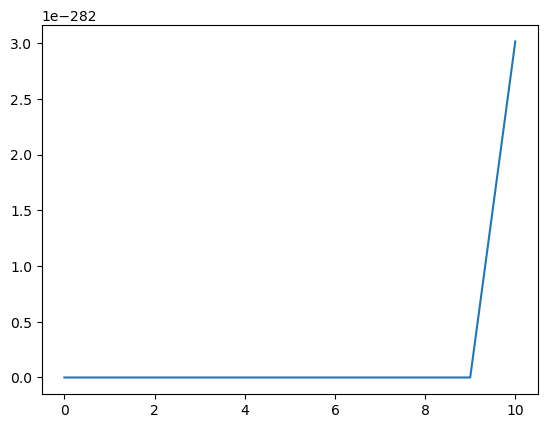

In [13]:
# Setting Initial Condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 5,
                   sigma = 0.5) # Gaussin IC
    res = np.float64(res)
    IC.append(res)
u[0][1] = IC # Populating initial condition in array u

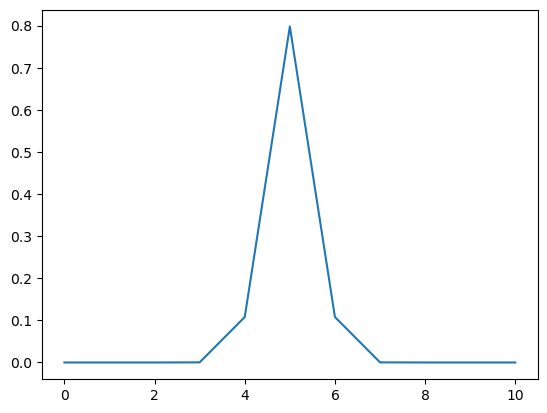

In [14]:
plt.plot(Xs,u[0][1])
plt.show()

In [8]:
for j in range(0,100):
    #Masking u at current time step based on sign of velocity at point
    neg_c = np.where(wx[0][1] > 0, u[j][1],0)
    pos_c = np.where(wx[0][1] < 0, u[j][1],0)
    zero_c = np.where(wx[0][1] != 0, u[j][1],0)
    



IndexError: index 10 is out of bounds for axis 0 with size 10

In [26]:
#Finite Difference Scheme

for j in range(0,Nt-1):
    for i in range(0,Nx-1):
        
        #Defining velocity at u[i], u[i-1], u[i-2],u[i+1],and u[i+2]
        
        c_x = (mean_sl**2) * wx[0][1][i] / w[0][1][i] / dt 
        cx_x = (mean_sl**2)/dt * (wxx[0][1][i]*w[0][1][i]-wx[0][1][i]**2) / (w[0][1][i]**2)
  
        if i == 0:
            
            c_xminus1 = (mean_sl**2) * wx[0][1][-1] / w[0][1][-1] / dt
            c_xminus2 = (mean_sl**2) * wx[0][1][-2] / w[0][1][-2] / dt
            
        elif i == 1:
            
            c_xminus1 = (mean_sl ** 2) * wx[0][1][0] / w[0][1][0] / dt
            c_xminus2 = (mean_sl ** 2) * wx[0][1][-1] / w[0][1][-1] / dt
            
        else:
            
            c_xminus1 = (mean_sl ** 2) * wx[0][1][i-1] / w[0][1][i-1] / dt
            c_xminus2 = (mean_sl ** 2) * wx[0][1][i-2] / w[0][1][i-2] / dt
            
        if i == Nt:
            
            c_xplus1 = (mean_sl**2) * wx[0][1][0] / w[0][1][0] / dt
            c_xplus2 = (mean_sl**2) * wx[0][1][1] / w[0][1][1] / dt
            
        elif i == (Nt - 1):
            
            c_xplus1 = (mean_sl ** 2) * wx[0][1][-1] / w[0][1][-1] / dt
            c_xplus2 = (mean_sl ** 2) * wx[0][1][0] / w[0][1][0] / dt
            
        else:
            
            c_xplus1 = (mean_sl ** 2) * wx[0][1][i+1] / w[0][1][i+1] / dt
            c_xplus2 = (mean_sl ** 2) * wx[0][1][i+2] / w[0][1][i+2] / dt
  
        
        #Calcutlting u(x) at future timesteps
        
        
        if c_x > 0 and c_xminus1 > 0 and c_xminus2 > 0:
            if i == 0:
                
                diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][Nx])
                advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(3* c_x * u[j][1][i] - 4 * c_xminus1 * u[j][1][Nx] + c_xminus2 * u[j][1][Nx-1]))
               
                
                u[j + 1][1][i] = u[j][1][i] + diffusion + advection
                
            elif i == 1:
                
                diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
                advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(3* c_x * u[j][1][i] - 4 * c_xminus1 * u[j][1][i-1] + c_xminus2 * u[j][1][Nx]))
                
                u[j + 1][1][i] = u[j][1][i] + diffusion + advection
            
            else:
                
                diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
                advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(3* c_x * u[j][1][i] - 4 * c_xminus1 * u[j][1][i-1] + c_xminus2 * u[j][1][i-2])) 
                
                u[j + 1][1][i] = u[j][1][i] + diffusion + advection 
        
        elif c_x < 0 and c_xplus1 < 0 and c_xplus2 < 0:
            if i == Nx:
                
                diffusion = r * (u[j][1][0] - 2 * u[j][1][i] + u[j][1][i - 1])
                advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(-c_xplus2 * u[j][1][1] +4 * c_xplus1 * u[j][1][0] - 3 * c_x * u[j][1][i])) 
               
                u[j + 1][1][i] = u[j][1][i] + diffusion + advection
                
            elif i == (Nx-1):
                
                diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
                advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(-c_xplus2 * u[j][1][0] +4 * c_xplus1 * u[j][1][i+1] - 3 * c_x * u[j][1][i]))
                
                u[j + 1][1][i] = u[j][1][i] + diffusion + advection 
           
            else:
                
                diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
                advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(-c_xplus2 * u[j][1][i+2] +4 * c_xplus1 * u[j][1][i+1] - 3 * c_x * u[j][1][i]))
                
                u[j + 1][1][i] = u[j][1][i] + diffusion + advection 
       
    else:
        if i == 0:
            diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][-1])
            advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(c_xplus1 * u[j][1][i + 1] - c_xminus1 * u[j][1][-1]))
                    
            u[j + 1][1][i] = u[j][1][i] + diffusion + advection 
        
        elif i == Nx:
            
            diffusion = r * (u[j][1][0] - 2 * u[j][1][i] + u[j][1][i - 1])
            advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(c_xplus1 * u[j][1][0] - c_xminus1 * u[j][1][i-1]))
                    
            u[j + 1][1][i] = u[j][1][i] + diffusion + advection 

        else:
            
            diffusion = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
            advection = -dt*(cx_x*u[j][1][i] + (1/(2*dx))*(c_xplus1 * u[j][1][i+1] - c_xminus1 * u[j][1][i-1]))
                    
            u[j + 1][1][i] = u[j][1][i] + diffusion + advection 

    
    area = integrate(u = u[j + 1][1],
                     dx = dx,
                     x_vals = Xs)
    u[j+1][1] = u[j+1][1]/area
    
    percent_comp = ((j+2)/(Nt))*100
    if ( percent_comp % 1 == 0):
        print(str(percent_comp)," %")
    if(percent_comp % 10 == 0):
        filename = "/Users/rhemitoth/Documents/Fall 2022/Math 19a/finalproject/RT_Math19A_Final/np_checkpoints/checkpoint{var}".format(var = str(percent_comp))
        np.save(filename, u)
    if j >= 2000:
        converge_YN = converge(current_t = u[j][1],
                              t_minus1000 = u[j-1000][1],
                              t_minus2000 = u[j-2000][1])
        if converge_YN == True:
            print("Model Converged")
            break
    


1.0  %
2.0  %
3.0  %
4.0  %
5.0  %
6.0  %
8.0  %
9.0  %
10.0  %
11.0  %
12.0  %
13.0  %
15.0  %
16.0  %
17.0  %
18.0  %
19.0  %
20.0  %
21.0  %
22.0  %
23.0  %
24.0  %
25.0  %
26.0  %
27.0  %
30.0  %
31.0  %
32.0  %
33.0  %
34.0  %
35.0  %
36.0  %
37.0  %
38.0  %
39.0  %
40.0  %
41.0  %
42.0  %
43.0  %
44.0  %
45.0  %
46.0  %
47.0  %
48.0  %
49.0  %
50.0  %
51.0  %
52.0  %
53.0  %
54.0  %
59.0  %
60.0  %
61.0  %
62.0  %
63.0  %
64.0  %
65.0  %
66.0  %
67.0  %
68.0  %
69.0  %
70.0  %
71.0  %
72.0  %
73.0  %
74.0  %
75.0  %
76.0  %
77.0  %
78.0  %
79.0  %
80.0  %
81.0  %
82.0  %
83.0  %
84.0  %
85.0  %
86.0  %
87.0  %
88.0  %
89.0  %
90.0  %
91.0  %
92.0  %
93.0  %
94.0  %
95.0  %
96.0  %
97.0  %
98.0  %
99.0  %
100.0  %


In [163]:
#Normalized Root Mean Squared Error
error = rmse(model = u,
           true = steady_state_u,
           nx = Nx,
           t = Nt-1)

print("Root Mean Squared Error = " + str(error))

Root Mean Squared Error = 0.09784102417398448


In [155]:
#Checking for conservation

res = integrate(u = u[Nt-1][1],
              dx = dx,
              x_vals = Xs)
print(res)

1.0000000000000013


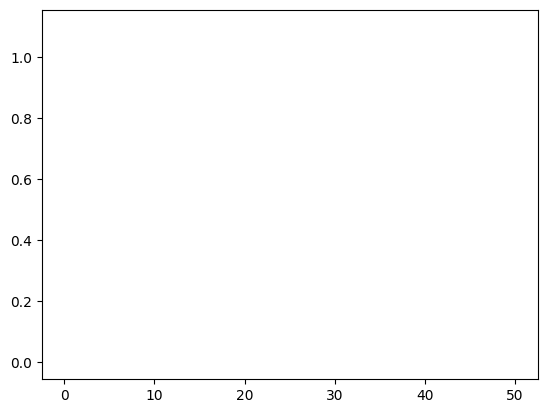

In [156]:
# Animation
fig1, ax1 = plt.subplots()
camera = Camera(fig1)
for i in range(Nt):
    Ys= u[i][1]
    if i%500 == 0:
        if i == 0:
            ax1.plot(w[0][0], w[0][1], color = "#5a5a5a", label = "w(x)", linestyle = "dashed")
            x = ax1.plot(Xs, Ys, color="#959e19", label="u(x,t)")
            y = ax1.plot(Xs,steady_state_u[0][1], color = 'black', linestyle = 'dotted', label = "steady state u(x,t)")
        else:
            ax1.plot(w[0][0], w[0][1], color="#5a5a5a", linestyle="dashed")
            x = ax1.plot(Xs, Ys, color="#959e19")
            y = ax1.plot(Xs, steady_state_u[0][1], color='black', linestyle='dotted')
        ax1.legend(loc="upper right")

        camera.snap()
animation = camera.animate()
animation.save('AdvectionDiffusion_CDA.mp4', writer = 'ffmpeg')

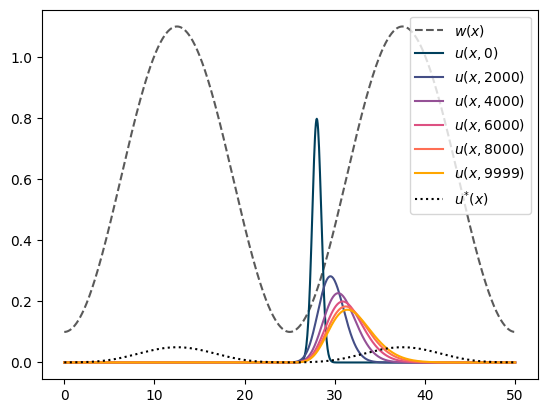

In [157]:
# Plot
fig2 = plt.figure()
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]
plt.plot(Xs,w[0][1], color = "#5a5a5a", label = r"$w(x)$", linestyle = "dashed")
plt.plot(Xs,t0, label = r'$u(x,0)$', color = "#003f5c" )
plt.plot(Xs,t1, label = fr'$u(x,{int(0.2*Nt)})$', color = "#444e86")
plt.plot(Xs,t2, label = fr'$u(x,{int(0.4*Nt)})$', color = "#955196")
plt.plot(Xs,t3, label = fr'$u(x,{int(0.6*Nt)})$', color = "#dd5182")
plt.plot(Xs,t4, label = fr'$u(x,{int(0.8*Nt)})$', color = "#ff6e54")
plt.plot(Xs,t5, label =fr'$u(x,{int(Nt-1)})$', color = "#ffa600")
plt.plot(Xs,steady_state_u[0][1], color = 'black', linestyle = 'dotted', label = r"$u^{*}(x)$")
plt.legend(loc="upper right")
plt.savefig("AdvectionDiffusion.png", dpi = 350)
plt.show()

